✅ Project Goal Build an image classification model (cats vs. dogs) using:

PyTorch ✅ Transfer_Learning(MobileNet)

TensorFlow

Data Preparation Use tensorflow.keras.preprocessing

Resize, normalize

Split into train/test (or train/val/test) using sklearn. model_selection.train_test_split

Model Definition Build a CNN

Or use transfer learning (ResNet or MobileNet)

Training Loop Track accuracy and loss using Matplotlib

Save best model weights

Evaluation Confusion matrix

Accuracy, precision, recall using sklearn.metrics

Visualization Sample predictions

Learning curves

Dataset Using Kaggle's Dogs vs. Cats dataset: Kaggle Dataset Link: https://www.kaggle.com/datasets/biaiscience/dogs-vs-cats

Using colab with "cuda" --> GPU

In [ ]:
from google.colab import files
files.upload()

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d biaiscience/dogs-vs-cats
!unzip -q dogs-vs-cats.zip -d data

Dataset URL: https://www.kaggle.com/datasets/biaiscience/dogs-vs-cats
License(s): DbCL-1.0
 97% 796M/817M [00:03<00:00, 149MB/s]
100% 817M/817M [00:03<00:00, 218MB/s]


In [4]:
import os
# Replace 'path/to/unzipped_folder' with the actual path
FOLDER_PATH = 'dogs-vs-cats.zip'
try:
  item_count = len(os.listdir(FOLDER_PATH))
  print(f"There are {item_count} items in the foler {FOLDER_PATH}")
except FileNotFoundError:
  print(f"The folder {FOLDER_PATH} does not exist.")
except Exception as e:
  print(f"An error occurred: {e}")

An error occurred: [Errno 20] Not a directory: 'dogs-vs-cats.zip'


In [5]:
for root, dirs, files in os.walk("data"):
  print(root)
  for d in dirs:
    print("  Folder", d)

data
  Folder test
  Folder train
data/test
  Folder test
data/test/test
data/train
  Folder train
data/train/train


In [6]:
import shutil
source_dir = 'data/train/train'
target_base = 'data/train/sorted'

os.makedirs(f"{target_base}/cat", exist_ok=True)
os.makedirs(f"{target_base}/dog", exist_ok=True)

for filename in os.listdir(source_dir):
  if filename.startswith('cat' or 'cats'):
    shutil.move(os.path.join(source_dir, filename), os.path.join(target_base, 'cat', filename))
  elif filename.startswith('dog' or 'dogs'):
    shutil.move(os.path.join(source_dir, filename), os.path.join(target_base, 'dog', filename))

In [7]:
for root, dirs, files in os.walk('data'):
  print(root)
  for d in dirs:
    print("  Folder", d)

data
  Folder test
  Folder train
data/test
  Folder test
data/test/test
data/train
  Folder sorted
  Folder train
data/train/sorted
  Folder dog
  Folder cat
data/train/sorted/dog
data/train/sorted/cat
data/train/train


In [8]:
cat_files = len(os.listdir('data/train/sorted/cat'))
dog_files = len(os.listdir('data/train/sorted/dog'))

print(f" Cats: {cat_files}")
print(f" Dogs: {dog_files}")

 Cats: 12500
 Dogs: 12500


important to make sure the dataset is already split into
1. data/train/sorted/cat/
2. data/train/sorted/dog/

Importing Libraries

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

## After some loops --> going to add Augmentations for MobileNetV2

In [10]:
# data_dir = 'data/train/sorted'
# IMAGE_SIZE = 128
# BATCH_SIZE = 32

# transform = transforms.Compose([
#     transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
#     transforms.ToTensor(),
#     transforms.Normalize([.5]*3, [.5]*3) # Normalize[-1, 1]
# ])

# dataset = datasets.ImageFolder(data_dir, transform = transform)

# train_size = int(.8 * len(dataset))
# val_size = len(dataset) - train_size
# train_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size])

# train_loader = DataLoader(train_data, batch_size= BATCH_SIZE, shuffle = True)
# val_loader = DataLoader(val_data, batch_size = BATCH_SIZE, shuffle = False)

# class_names = dataset.classes
# print(class_names)

['cat', 'dog']


In [26]:
data_dir = 'data/train/sorted'
IMAGE_SIZE = 128
BATCH_SIZE = 32

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness = 0.2, contrast = 0.2),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean =[.485, .456, .406], std=[.229, .224, .225])

])
dataset = datasets.ImageFolder(data_dir, transform = train_transform)
train_size = int(.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size])
train_data = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True)
val_data = DataLoader(val_data, batch_size = BATCH_SIZE, shuffle = False)

class_names = dataset.classes
print(class_names)

['cat', 'dog']


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Load pretrained MobileNetV2
* Freeze base layers with replace classifier
## NOTE: after some loop --> making last few layers unfreeze rather than before

In [28]:
# model = models.mobilenet_v2(pretrained = True)

# for param in model.features.parameters():
#   param.requires_grad = False

# model.classifier[1] = nn.Sequential(
#     nn.Dropout(0.3),
#     nn.Linear(model.last_channel, 1) # Binary Classification

# )
# model = model.to(device)

MobileNetV2 has 18 blucks in . features(0 to 17)
features[10:]--> unfreezing the last 8 blocks

In [42]:
model = models.mobilenet_v2(pretrained = True)

for param in model.features.parameters():
  param.requires_grad = False

for param in model.features[-10:].parameters():
  param.requires_grad = True

model.classifier[1] = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.last_channel, 1) # Binary Classification

)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loss and optimizer

In [43]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(params = model.parameters(), lr = 1e-3) # Chenged from 1e-3 to -4
#Scheduler Reduce LR if val loss plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1, #Reduce by 10x and patience -->wait for 2 epochs of no improvement
    patience=2,
    verbose = True
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training Loop

In [44]:
def train_model(model, train_loader, val_loader, optimizer, loss_fn, scheduler, epochs=5):
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()
                preds = torch.sigmoid(outputs)
                preds_class = (preds > 0.5).int()
                correct += (preds_class == labels.int()).sum().item()
                total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {correct / total:.2%}")

    return train_losses, val_losses


Train

In [45]:
train_loss, val_loss = train_model(model, train_loader, val_loader, optimizer, loss_fn, scheduler, epochs=5)

Epoch 1/5 - Train Loss: 0.1668, Val Loss: 0.1016, Val Acc: 95.90%
Epoch 2/5 - Train Loss: 0.1041, Val Loss: 0.1091, Val Acc: 95.82%
Epoch 3/5 - Train Loss: 0.0833, Val Loss: 0.1012, Val Acc: 96.00%
Epoch 4/5 - Train Loss: 0.0618, Val Loss: 0.1121, Val Acc: 95.94%
Epoch 5/5 - Train Loss: 0.0480, Val Loss: 0.1062, Val Acc: 96.02%


## Plot accuracy curve
Just 5 epochs we plot them manually or we nee to change the loop which is not important in this case

In [51]:
val_accuracies = [95.90, 95.82, 96.00, 95.94, 96.02]
train_losses = [0.1668, 0.1041, 0.0833, 0.0618, 0.0480]
val_losses = [0.1016, 0.1091, 0.1012, 0.1121, 0.1062]
val_accuracies = [acc / 100 for acc in val_accuracies]

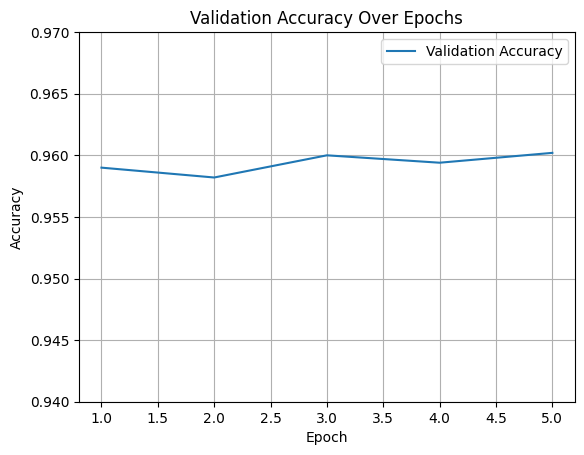

In [52]:
import matplotlib.pyplot as plt

epochs = range(1, 6)
val_accuracies = [95.90, 95.82, 96.00, 95.94, 96.02]
val_accuracies = [acc / 100 for acc in val_accuracies]  # convert to 0–1 scale

plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.title("Validation Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0.94, 0.97)  # optional: zoom in
plt.legend()
plt.grid(True)
plt.show()

## Show predictions

In [53]:
import matplotlib.pyplot as plt

def show_predictions(model, dataloader, class_names, device, num_images=6):
    model.eval()
    images, labels = next(iter(dataloader))
    images, labels = images[:num_images].to(device), labels[:num_images].to(device)

    with torch.no_grad():
        outputs = model(images)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).int()

    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        ax = plt.subplot(2, 3, i + 1)
        img = images[i].permute(1, 2, 0).cpu().numpy()  # (C, H, W)-->(H, W, C)

        plt.imshow(img)
        plt.axis("off")
        true_label = class_names[int(labels[i].item())]
        pred_label = class_names[int(preds[i].item())]
        plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.tight_layout()
    plt.show()


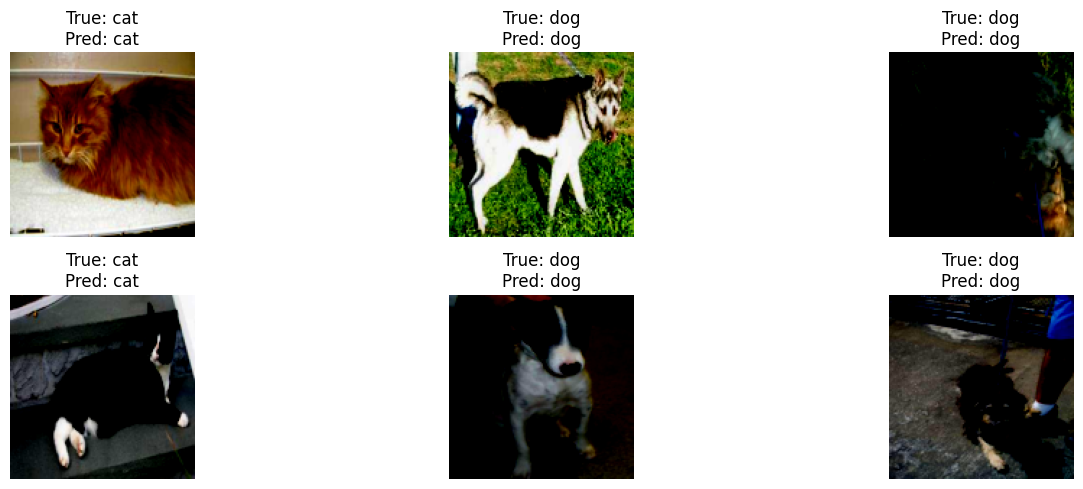

In [54]:
show_predictions(model, val_loader, class_names, device)